# Style Optimizing

This time we will try to recreate the style of our image. We are going to use a VGG network that has multiple outputs at five different convolutions in the network. Once we have those five outputs instead of comparing pixels directly in this case we calculate  MSE between gram matrices of those outputs and then optimize.

NOTE - We are optimising the input image to reduce loss between output of convolutional layers(compared with output from layers when we pass the style/content image) of VGG16 model(we don't optimise weights since they are pretrained). Also we use the optimized input image as final prediction instead of output from convolutional layers. Usually we train weights and biases of neural network by comparing loss of predictions vs actual answer but in this case we optimise/make changes in the input image and weights are not touched.

In [1]:
import tensorflow as tf
if tf.__version__.startswith('2'):
    tf.compat.v1.disable_eager_execution()

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K

import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fmin_l_bfgs_b
from datetime import datetime

In [2]:
def VGG16_AvgPool(shape):
    # we want to account for features across the entire image so get rid of the maxpool which throws away information and use average      # pooling instead.
    vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)

    i = vgg.input
    x = i
    for layer in vgg.layers:
        if layer.__class__ == MaxPooling2D:
            # replace it with average pooling
            x = AveragePooling2D()(x)
        else:
            x = layer(x)

    return Model(i, x)

def VGG16_AvgPool_CutOff(shape, num_convs):
    # this function creates a partial model because we don't need the full VGG network instead we need to stop at an intermediate 
    # convolution. Therefore this function allows us to specify how many convolutions we need
    # there are 13 convolutions in total we can pick any of them as the "output" of our content model

    if num_convs < 1 or num_convs > 13:
        print("num_convs must be in the range [1, 13]")
        return None

    model = VGG16_AvgPool(shape)

    n = 0
    output = None
    for layer in model.layers:
        if layer.__class__ == Conv2D:
            n += 1
        if n >= num_convs:
            output = layer.output
            break

    return Model(model.input, output)

In [3]:
# since VGG accepts BGR this function allows us to convert our values back to RGB so we can plot it using matplotlib
# so this basically reverses the keras function - preprocess input
def unpreprocess(img):
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 126.68
    img = img[..., ::-1]
    return img

def scale_img(x):
    x = x - x.min()
    x = x / x.max()
    return x

In [4]:
def gram_matrix(img):
  # input is (H, W, C) (C = # feature maps)
  # we first need to convert it to (C, H*W)
  X = K.batch_flatten(K.permute_dimensions(img, (2, 0, 1)))
  
  # now, calculate the gram matrix
  # gram = XX^T / N
  # the constant is not important since we'll be weighting these
  G = K.dot(X, K.transpose(X)) / img.get_shape().num_elements()
  return G

In [5]:
def style_loss(y, t):
  return K.mean(K.square(gram_matrix(y) - gram_matrix(t)))

In [6]:
# let's generalize this and put it into a function
def minimize(fn, epochs, batch_shape):
  t0 = datetime.now()
  losses = []
  x = np.random.randn(np.prod(batch_shape))
  for i in range(epochs):
    x, l, _ = fmin_l_bfgs_b(
      func=fn,
      x0=x,
      maxfun=20
    )
    x = np.clip(x, -127, 127)
    print("iter=%s, loss=%s" % (i, l))
    losses.append(l)

  print("duration:", datetime.now() - t0)
  plt.plot(losses)
  plt.show()

  newimg = x.reshape(*batch_shape)
  final_img = unpreprocess(newimg)
  return final_img[0]

# Modelling

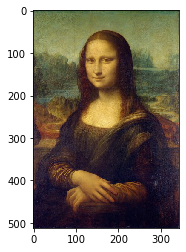

In [7]:
path = 'images/style/monalisa.jpg'
img = image.load_img(path)

plt.imshow(img)
plt.show()

In [8]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

batch_shape = x.shape
shape = x.shape[1:]
print(batch_shape)
print(shape)

(1, 512, 343, 3)
(512, 343, 3)


In [9]:
# load the complete model
vgg = VGG16_AvgPool(shape)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1:0


In [10]:
# index 0 correspond to the original vgg with maxpool so we do get_output_at(1) which corresponds to vgg with avg pool
symbolic_conv_outputs = [
  layer.get_output_at(1) for layer in vgg.layers \
  if layer.name.endswith('conv1')
]
# we collect all the convolutional layers in this list because we will need to take output from all of them
symbolic_conv_outputs

[<tf.Tensor 'block1_conv1_1/Relu:0' shape=(None, 512, 343, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1_1/Relu:0' shape=(None, 256, 171, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1_1/Relu:0' shape=(None, 128, 85, 256) dtype=float32>,
 <tf.Tensor 'block4_conv1_1/Relu:0' shape=(None, 64, 42, 512) dtype=float32>,
 <tf.Tensor 'block5_conv1_1/Relu:0' shape=(None, 32, 21, 512) dtype=float32>]

In [11]:
# make a big model that outputs multiple layers' outputs(outputs from all layers stored in list symbolic_conv_outputs)
multi_output_model = Model(vgg.input, symbolic_conv_outputs)
multi_output_model.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1:0
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            multiple             0           input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 343, 64) 1792        input_1[1][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 512, 343, 64) 36928       block1_conv1[1][0]               
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 256, 171, 64) 0          

In [12]:
# calculate the targets that are output at each layer
style_layers_outputs = [K.variable(y) for y in multi_output_model.predict(x)]

# calculate the total style loss
loss = 0
for symbolic, actual in zip(symbolic_conv_outputs, style_layers_outputs):
  # gram_matrix() expects a (H, W, C) as input
  loss += style_loss(symbolic[0], actual[0])

grads = K.gradients(loss, multi_output_model.input)

In [13]:
multi_output_model.input

<tf.Tensor 'input_1:0' shape=(None, 512, 343, 3) dtype=float32>

In [14]:
multi_output_model.output

[<tf.Tensor 'block1_conv1_1/Relu:0' shape=(None, 512, 343, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1_1/Relu:0' shape=(None, 256, 171, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1_1/Relu:0' shape=(None, 128, 85, 256) dtype=float32>,
 <tf.Tensor 'block4_conv1_1/Relu:0' shape=(None, 64, 42, 512) dtype=float32>,
 <tf.Tensor 'block5_conv1_1/Relu:0' shape=(None, 32, 21, 512) dtype=float32>]

In [15]:
style_layers_outputs

[<tf.Variable 'Variable:0' shape=(1, 512, 343, 64) dtype=float32>,
 <tf.Variable 'Variable_1:0' shape=(1, 256, 171, 128) dtype=float32>,
 <tf.Variable 'Variable_2:0' shape=(1, 128, 85, 256) dtype=float32>,
 <tf.Variable 'Variable_3:0' shape=(1, 64, 42, 512) dtype=float32>,
 <tf.Variable 'Variable_4:0' shape=(1, 32, 21, 512) dtype=float32>]

In [16]:
symbolic_conv_outputs

[<tf.Tensor 'block1_conv1_1/Relu:0' shape=(None, 512, 343, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1_1/Relu:0' shape=(None, 256, 171, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1_1/Relu:0' shape=(None, 128, 85, 256) dtype=float32>,
 <tf.Tensor 'block4_conv1_1/Relu:0' shape=(None, 64, 42, 512) dtype=float32>,
 <tf.Tensor 'block5_conv1_1/Relu:0' shape=(None, 32, 21, 512) dtype=float32>]

In [17]:
get_loss_and_grads = K.function(
  inputs=[multi_output_model.input],
  outputs=[loss] + grads
)

def get_loss_and_grads_wrapper(x_vec):
    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)

iter=0, loss=7626.755859375
iter=1, loss=1514.7252197265625
iter=2, loss=166.46388244628906
iter=3, loss=75.32965087890625
iter=4, loss=46.91262435913086
iter=5, loss=32.804386138916016
iter=6, loss=25.719038009643555
iter=7, loss=20.943038940429688
iter=8, loss=17.945262908935547
iter=9, loss=15.027190208435059
duration: 0:00:44.833575


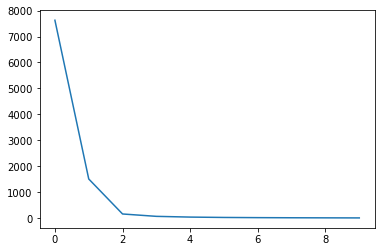

In [18]:
final_img = minimize(get_loss_and_grads_wrapper, 10, batch_shape)

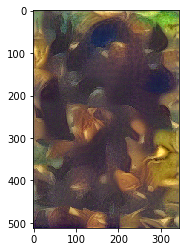

In [19]:
plt.imshow(scale_img(final_img))
plt.show()